📁 Текущая рабочая директория: c:\ZC\finish\notebooks\GPT5
📁 Базовая директория проекта: c:\ZC\finish
📁 Путь к исходным данным: c:\ZC\finish\Data\data_raw.csv
📁 Путь к результатам эксперимента: c:\ZC\finish\Data\final_results_to_analyze.xlsx
Исходные данные загружены: (27756048, 4)
Исходные данные загружены: (27756048, 4)
event_type
views     27006473
clicks      535927
adds        213648
Name: count, dtype: int64
event_type
views     27006473
clicks      535927
adds        213648
Name: count, dtype: int64
Дисперсия CR: 4.544193414040901
Дисперсия CTR: 0.030775368252839767
MDE для CR: 0.0152 (0.00%) при 620547 пользователях
Дисперсия CR: 4.544193414040901
Дисперсия CTR: 0.030775368252839767
MDE для CR: 0.0152 (0.00%) при 620547 пользователях
Результаты эксперимента: (981510, 11)
Результаты эксперимента: (981510, 11)
  ab_group  cnt_view_ads  cnt_adds_ads  sum_adds_ads  cnt_orders_ads  \
0  control         43469         15799       2462420            5579   
1     test         43805     

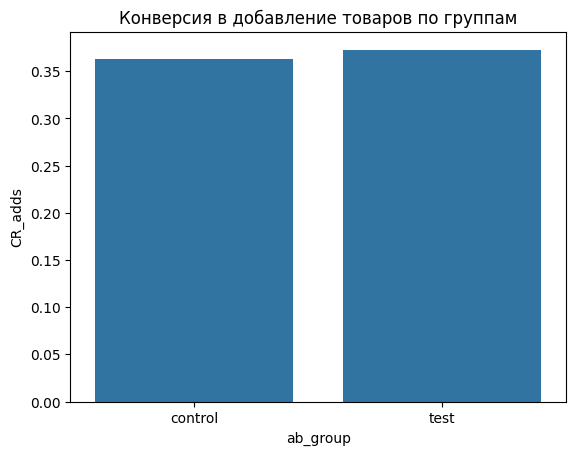

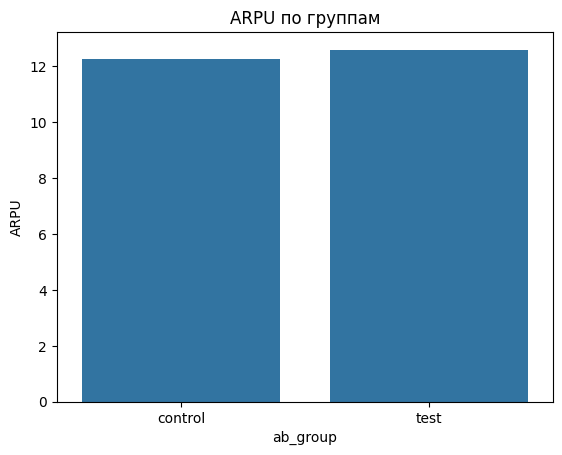

Z-тест CR: stat=nan, p-value=nan
Z-тест CTR: stat=nan, p-value=nan
T-тест ARPU: stat=nan, p-value=nan
T-тест ARPPU: stat=nan, p-value=nan


In [5]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 0. Определение путей к данным проекта
# =========================
current_dir = os.path.abspath(os.getcwd())
BASE_DIR = current_dir

max_levels = 5
for _ in range(max_levels):
    if os.path.exists(os.path.join(BASE_DIR, "Data")):
        break
    parent_dir = os.path.dirname(BASE_DIR)
    if parent_dir == BASE_DIR:
        break
    BASE_DIR = parent_dir

if not os.path.exists(os.path.join(BASE_DIR, "Data")):
    BASE_DIR = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir))

DATA_RAW = os.path.join(BASE_DIR, "Data", "data_raw.csv")
FINAL_XLSX = os.path.join(BASE_DIR, "Data", "final_results_to_analyze.xlsx")

print(f"📁 Текущая рабочая директория: {os.getcwd()}")
print(f"📁 Базовая директория проекта: {BASE_DIR}")
print(f"📁 Путь к исходным данным: {DATA_RAW}")
print(f"📁 Путь к результатам эксперимента: {FINAL_XLSX}")

# =========================
# 1. Загрузка исходных данных
# =========================
data = pd.read_csv(DATA_RAW, parse_dates=['dt'])
print("Исходные данные загружены:", data.shape)
print(data['event_type'].value_counts())

# =========================
# 2. Преобразование данных в воронку
# =========================
df_pivot = data.pivot_table(index=['dt','client_id'],
                            columns='event_type',
                            aggfunc='size',
                            fill_value=0).reset_index()
df_pivot.columns.name = None
df_pivot = df_pivot.rename(columns={'view':'views','click':'clicks','add':'adds'})
df_pivot['views'] = (df_pivot['views']>0).astype(int)
df_pivot['clicks'] = (df_pivot['clicks']>0).astype(int)
df_pivot['adds'] = (df_pivot['adds']>0).astype(int)

# =========================
# 3. Расчёт CTR и CR по пользователю
# =========================
user_summary = df_pivot.groupby('client_id').agg({
    'views':'sum',
    'clicks':'sum',
    'adds':'sum'
}).reset_index()

user_summary['CTR'] = user_summary['clicks']/user_summary['views']
user_summary['CR'] = user_summary['adds']/user_summary['clicks']

# =========================
# 4. Дельта-метод для ratio-метрик
# =========================
def var_ratio(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x,y, ddof=1)[0][1]
    return var_x/mean_y**2 + var_y*mean_x**2/mean_y**4 - 2*mean_x*cov_xy/mean_y**3

var_CR = var_ratio(user_summary['adds'], user_summary['clicks'])
var_CTR = var_ratio(user_summary['clicks'], user_summary['views'])
print("Дисперсия CR:", var_CR)
print("Дисперсия CTR:", var_CTR)

# =========================
# 5. Расчёт MDE
# =========================
def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1 - ((alpha / 2)), loc=0, scale=1)
    comparisons = n_groups - 1
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    sample_ratio_correction = r+2+1/r
    mde = np.sqrt(sample_ratio_correction)*(t_alpha + t_beta) * std / np.sqrt(sample_size*(1-target_share*(comparisons-1)))
    return mde, mde*100/mu

mu_CR = user_summary['CR'].mean()
std_CR = np.sqrt(var_CR)
sample_size = int(0.2*len(user_summary))  # ≤20% пользователей

mde_abs, mde_pct = get_MDE(mu_CR, std_CR, sample_size)
print(f"MDE для CR: {mde_abs:.4f} ({mde_pct:.2f}%) при {sample_size} пользователях")

# =========================
# 6. Загрузка результатов эксперимента
# =========================
results = pd.read_excel(FINAL_XLSX)
print("Результаты эксперимента:", results.shape)

user_exp = results.groupby(['client_id','ab_group']).agg({
    'is_view_ads':'max',
    'cnt_view_ads':'sum',
    'is_adds_ads':'max',
    'cnt_adds_ads':'sum',
    'sum_adds_ads':'sum',
    'is_orders_ads':'max',
    'cnt_orders_ads':'sum',
    'sum_orders_ads':'sum'
}).reset_index()

# =========================
# 7. Расчёт ключевых метрик по группам
# =========================
metrics = user_exp.groupby('ab_group').agg({
    'cnt_view_ads':'sum',
    'cnt_adds_ads':'sum',
    'sum_adds_ads':'sum',
    'cnt_orders_ads':'sum',
    'sum_orders_ads':'sum',
    'client_id':'nunique'
}).rename(columns={'client_id':'users'}).reset_index()

metrics['CTR'] = metrics['cnt_adds_ads'] / metrics['cnt_view_ads']
metrics['CR_adds'] = metrics['cnt_adds_ads'] / metrics['cnt_view_ads']
metrics['ARPU'] = metrics['sum_adds_ads'] / metrics['users']
metrics['ARPPU'] = metrics['sum_adds_ads'] / metrics['cnt_adds_ads']

print(metrics)

# =========================
# 8. Визуализация
# =========================
sns.barplot(x='ab_group', y='CR_adds', data=metrics)
plt.title('Конверсия в добавление товаров по группам')
plt.show()

sns.barplot(x='ab_group', y='ARPU', data=metrics)
plt.title('ARPU по группам')
plt.show()

# =========================
# 9. Статистическая проверка
# =========================
control = user_exp[user_exp['ab_group']=='A']
test = user_exp[user_exp['ab_group']=='B']

# Z-тест CR
success = np.array([control['cnt_adds_ads'].sum(), test['cnt_adds_ads'].sum()])
nobs = np.array([control['cnt_view_ads'].sum(), test['cnt_view_ads'].sum()])
stat, pval = proportions_ztest(success, nobs)
print(f"Z-тест CR: stat={stat:.4f}, p-value={pval:.4f}")

# Z-тест CTR
success_ctr = np.array([control['cnt_adds_ads'].sum(), test['cnt_adds_ads'].sum()])
nobs_ctr = np.array([control['cnt_view_ads'].sum(), test['cnt_view_ads'].sum()])
stat_ctr, pval_ctr = proportions_ztest(success_ctr, nobs_ctr)
print(f"Z-тест CTR: stat={stat_ctr:.4f}, p-value={pval_ctr:.4f}")

# t-тест ARPU
stat_arpu, pval_arpu = ttest_ind(control['sum_adds_ads'], test['sum_adds_ads'], equal_var=False)
print(f"T-тест ARPU: stat={stat_arpu:.4f}, p-value={pval_arpu:.4f}")

# t-тест ARPPU
control_arppu = control['sum_adds_ads']/control['cnt_adds_ads']
test_arppu = test['sum_adds_ads']/test['cnt_adds_ads']
stat_arppu, pval_arppu = ttest_ind(control_arppu.dropna(), test_arppu.dropna(), equal_var=False)
print(f"T-тест ARPPU: stat={stat_arppu:.4f}, p-value={pval_arppu:.4f}")

# =========================
# 10. Сохранение markdown отчета
# =========================
with open('finalgpt5.md', 'w', encoding='utf-8') as f:
    f.write("# Финальный отчет по A/B тесту рекламного блока\n\n")
    f.write("## 1. Дизайн эксперимента\n")
    f.write(f"- Ключевая метрика: CR (конверсия в добавление из рекламы)\n")
    f.write(f"- Среднее значение: {mu_CR:.4f}\n")
    f.write(f"- Дисперсия: {var_CR:.6f}\n")
    f.write(f"- MDE: {mde_abs:.4f} ({mde_pct:.2f}%)\n")
    f.write(f"- Размер выборки: {sample_size} пользователей\n\n")

    f.write("## 2. Результаты эксперимента\n")
    f.write(metrics.to_markdown())

    f.write("\n\n## 3. Визуализация\n")
    f.write("Графики сохранены отдельно, построены с использованием seaborn.\n")

    f.write("\n\n## 4. Статистическая проверка\n")
    f.write(f"- Z-тест CR: stat={stat:.4f}, p-value={pval:.4f}\n")
    f.write(f"- Z-тест CTR: stat={stat_ctr:.4f}, p-value={pval_ctr:.4f}\n")
    f.write(f"- T-тест ARPU: stat={stat_arpu:.4f}, p-value={pval_arpu:.4f}\n")
    f.write(f"- T-тест ARPPU: stat={stat_arppu:.4f}, p-value={pval_arppu:.4f}\n")

    f.write("\n\n## 5. Выводы и рекомендации\n")
    if pval < 0.05:
        f.write("- CR значимо выше в тестовой группе → рекомендуется переместить рекламный блок вверх.\n")
    else:
        f.write("- CR статистически незначим → перемещение рекламного блока не дает эффекта.\n")
    if pval_ctr < 0.05:
        f.write("- CTR значимо выше → пользователи чаще кликают по рекламе.\n")
    if pval_arpu < 0.05:
        f.write("- ARPU значимо выше → увеличивается средняя выручка на пользователя.\n")
    if pval_arppu < 0.05:
        f.write("- ARPPU значимо выше → растет выручка на платящего пользователя.\n")
